In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from math import log2

In [3]:
from scoutsy.db_ops import create_connection
from dotenv import load_dotenv
import pandas as pd
load_dotenv(".env", override=True)

True

In [7]:
db = 'data/wsdm_data.db'
# db = "data/db_for_reveresed_prompt.sqlite3"
conn = create_connection(db)
cur = conn.cursor()

In [8]:
get_query = """ SELECT T.title, TRL.topic_id, TRL.status,TRL.resource_id, R.content,R.n_tokens 
    FROM Topics T 
    JOIN TopicResourceLink TRL on TRL.topic_id = T.id
    JOIN Resources R on R.id = TRL.resource_id
    WHERE R.content IS NOT NULL AND TRL.status IN ("Accepted","Rejected");
    """
df = pd.read_sql_query(get_query, conn)
remove_topic = ["Time Management : Eisenhower Matrix","Arithmetics in Python"]
df = df[df.title.isin(remove_topic)==False]
# r = df.groupby("title").count()
# e = r[r.resource_id>1]["topic_id"]
# print(f"{e.sum()} resources in {e.shape[0]} topics , {e.mean():.2f} resources per topic")


In [25]:
df

,title,topic_id,status,resource_id,content,n_tokens
0,What is a sprint?,1,Rejected,1,welcome to another video of the agile \n...,993
1,What is a sprint?,1,Rejected,2,"A sprint is a short period of time, usually\no...",228
2,What is a sprint?,1,Accepted,3,hi my name is Stephanie I am a softwar...,1718
3,What is a sprint?,1,Rejected,4,Hi.\nMy name is Shane Paul O'Neil from City Co...,177
4,What is a sprint?,1,Rejected,5,Hello and Welcome to KnowledgeHut. Scrum is a ...,653
...,...,...,...,...,...,...
927,Techniques for controlling bleeding,55,Accepted,1043,Hi my name is Wee Chee and I’m a paramedic In ...,166
928,Techniques for controlling bleeding,55,Accepted,1046,[Music] \n there are many unfortunate even...,713
929,Techniques for controlling bleeding,55,Rejected,1047,but to start off we're going to go to ...,6126
930,Techniques for controlling bleeding,55,Rejected,1048,knowing you need surgery can be a sourc...,7251


In [9]:
results_query = """
SELECT
    topic_id,
    model_name,
    winner_resource_id,
    llm_response,
    input_token_usage,
    output_token_usage,
    error,
    status,
    pairs_evaluation_set_id,
    text,
    tag,
    description,
    "order",
    token_count_estimate,
    base_accepted_resource_id,
    accepted_resource_id,
    rejected_resource_id,
    Topics.title,
    Courses.title as course_title
FROM PairsPromptResult
JOIN PairsPrompt PP ON PairsPromptResult.pairs_prompt_id = PP.id
JOIN PairsEvaluationSet PES ON PP.pairs_evaluation_set_id = PES.id
JOIN Topics ON PES.topic_id = Topics.id
JOIN Courses ON Topics.course_id = Courses.id
WHERE "order" = "accepted_rejected" and tag="v1_no_force_prompt" 
"""

results_df = pd.read_sql_query(results_query, conn)
results_df.head(2)


,topic_id,model_name,winner_resource_id,llm_response,input_token_usage,output_token_usage,error,status,pairs_evaluation_set_id,text,tag,description,order,token_count_estimate,base_accepted_resource_id,accepted_resource_id,rejected_resource_id,title,course_title
0,50,gpt-4o-mini,937,candidate_1,4080.0,3.0,None,valid,18743,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,4021,936,937,935,Acute vs Chronic Stress,stress management and mental health
1,50,gpt-4o-mini,937,candidate_1,2448.0,3.0,None,valid,18744,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2389,936,937,940,Acute vs Chronic Stress,stress management and mental health


In [27]:
results_df["total"] = results_df["input_token_usage"] + results_df["output_token_usage"]
results_df.groupby("model_name").agg({"total":"mean"})

,total
model_name,
gpt-4o,8418.790064
gpt-4o-mini,8380.739615


In [28]:
results_df["error"].value_counts()

error
None                                                                                                                                                                                                                                                                                                              45427
Invalid level, it should be an integer or a string, not: 'Level'                                                                                                                                                                                                                                                     67
__Invalid response                                                                                                                                                                                                                                                                                                   25
_invalid response                                         

In [29]:
results_df["model_name"].unique()

array(['gpt-4o-mini', 'gpt-4o'], dtype=object)

In [30]:
results_df.groupby("model_name").agg({"input_token_usage":"sum","output_token_usage":"sum"})/1e3

,input_token_usage,output_token_usage
model_name,,
gpt-4o,191257.245,68.178
gpt-4o-mini,190183.067,68.103


In [63]:
# results_df = results_df[results_df["tag"]=="v1_summary_accepted_rejected"]
# results_df.shapeA
results_df = results_df[results_df["status"]=="valid"]
results_df.shape

(45427, 19)

In [31]:
results_df["accuracy"] = results_df.apply(lambda x : 1 if x["winner_resource_id"] == x["accepted_resource_id"] else 0, axis=1)

In [59]:
results_df.head()

,topic_id,model_name,winner_resource_id,llm_response,input_token_usage,output_token_usage,error,status,pairs_evaluation_set_id,text,tag,description,order,token_count_estimate,base_accepted_resource_id,accepted_resource_id,rejected_resource_id,title,title,accuracy
0,50,gpt-4o-mini,937,candidate_1,4080.0,3.0,None,valid,18743,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,4021,936,937,935,Acute vs Chronic Stress,stress management and mental health,1
1,50,gpt-4o-mini,937,candidate_1,2448.0,3.0,None,valid,18744,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2389,936,937,940,Acute vs Chronic Stress,stress management and mental health,1
2,50,gpt-4o-mini,937,candidate_1,1897.0,3.0,None,valid,18745,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,1838,936,937,943,Acute vs Chronic Stress,stress management and mental health,1
3,50,gpt-4o-mini,937,candidate_1,2776.0,3.0,None,valid,18746,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2717,936,937,945,Acute vs Chronic Stress,stress management and mental health,1
4,50,gpt-4o-mini,937,candidate_1,2061.0,3.0,None,valid,18747,I will provide you with a base document and a ...,v1_no_force_prompt,this_is_the_prompt_we_developed_with_reza_afte...,accepted_rejected,2002,936,937,948,Acute vs Chronic Stress,stress management and mental health,1


In [32]:
# compare with old
old_perf = pd.read_json(
    "data/old_res.json",
    orient="columns",
)
old_perf = old_perf[["voyage-large-2-instruct","Baseline"]]
old_perf = old_perf.reset_index().rename(columns={'index':"title"})



In [33]:
perf = results_df.groupby(["course_title","title","model_name","base_accepted_resource_id","tag"]).agg({"accuracy":"mean"}).reset_index().groupby(["course_title","title","model_name","tag"]).agg({"accuracy":"mean"}).reset_index()
perf

,course_title,title,model_name,tag,accuracy
0,Agile Scrum,What is a sprint?,gpt-4o,v1_no_force_prompt,0.888889
1,Agile Scrum,What is a sprint?,gpt-4o-mini,v1_no_force_prompt,0.805556
2,Agile Scrum,What is the difference between scrum and canban?,gpt-4o,v1_no_force_prompt,0.953125
3,Agile Scrum,What is the difference between scrum and canban?,gpt-4o-mini,v1_no_force_prompt,0.796875
4,Agile Scrum,What is the role of product owner?,gpt-4o,v1_no_force_prompt,0.773333
...,...,...,...,...,...
101,stress management and mental health,Body's reaction to Stress,gpt-4o-mini,v1_no_force_prompt,0.604762
102,stress management and mental health,Eustress vs Distress: Understanding Positive a...,gpt-4o,v1_no_force_prompt,0.638528
103,stress management and mental health,Eustress vs Distress: Understanding Positive a...,gpt-4o-mini,v1_no_force_prompt,0.580087
104,stress management and mental health,Stress vs Stressors,gpt-4o,v1_no_force_prompt,0.853333


In [49]:
input_cost = (results_df["input_token_usage"].sum() /1e6) * 5
output_cost = (results_df["output_token_usage"].sum() /1e6) * 15
total_cost = input_cost + output_cost
total_cost

951.9368799999999

In [30]:
with open('accuracy_min.txt', 'w') as file:
    for accuracy in perf['accuracy']:
        file.write(f"{accuracy:.2f}\n")

In [72]:
perf.pivot_table(index="title",columns=["model_name"],values=["accuracy"])

accuracy            
model_name                                            gpt-4o gpt-4o-mini
title                                                                   
Acute vs Chronic Stress                             0.838384    0.854545
Body's reaction to Stress                           0.715873    0.604762
Chain of Thought Prompting                          0.874747    0.826263
Comments in Python                                  0.901738    0.908163
Conditions in Python                                0.799320    0.625850
Cross Validation                                    0.819444    0.665123
Density-based Clustering                            0.740000    0.570000
Dictionaries in Python                              0.904762    0.735714
Error Handling in Python                            0.905612    0.780612
Eustress vs Distress: Understanding Positive an...  0.640109    0.580087
First aid: Burn treatment techniques                0.785714    0.748918
Functions in Python                                 0.766204    0.585648
Gradient Descent                                    0.933333    0.711111
Graphics in latex: including images and creatin...  0.856912    0.715873
Hierarchical Clustering                             0.638462    0.376923
Introducing Python                                  0.961538    0.763889
Iterative Prompting                                 0.853147    0.791209
K-Means Clustering Algorithm                        0.882353    0.647059
Latex document class                                0.661111    0.352778
Latex for scientific writing: equations, formul...  0.993056    0.979167
Linear Regression                                   0.855556    0.777778
Lists in Python                                     0.961111    0.760464
Lists in latex                                      0.815625    0.705208
Logistic Regression                                 0.790000    0.573333
Numeric Data Types in Python                        0.928571    0.819430
Overfitting vs Underfitting                         0.861111    0.703704
Parkinson’s Law                                     0.747253    0.584249
Prompt Elements                                     0.873626    0.815018
Register account on Overleaf                        0.866667    0.673333
Regression vs Classification                        0.902778    0.813492
Regularization                                      0.625000    0.479167
Resampling Method: Bootstrapping                    0.890625    0.833333
Section, paragraph in latex                         0.837302    0.694444
Setting SMART Goals                                 0.930712    0.817766
Simplified Large Language Model definition - GPT    0.864469    0.798535
Stress vs Stressors                                 0.853333    0.853333
Strings in Python                                   0.939394    0.772727
Supervised Learning vs Unsupervised Learning        0.968056    0.916667
System Prompts in LLM                               1.000000    1.000000
Tables in latex                                     0.950893    0.924107
Techniques for controlling bleeding                 0.695534    0.608333
Time Management : Getting Things Done (GTD) Method  0.840749    0.789141
Time Management : Pareto Analysis (a.k.a., the ...  0.787879    0.702020
Time Management : Pomodoro Technique                0.912393    0.846154
Time Management : Time Blocking Method              0.736264    0.573260
Time is a limited resource                          0.674074    0.574074
What is Prompt Engineering?                         0.840000    0.553333
What is a sprint?                                   0.888889    0.805556
What is the difference between scrum and canban?    0.953125    0.796875
What is the role of product owner?                  0.783595    0.693333
Zero-Shot, One-shot and Few-shot Prompting          0.945347    0.854701
difference between agile and scrum?                 0.741621    0.697917
what is the role of scrum master?    

In [15]:
final = perf.merge(old_perf, on="title")
final.rename(columns={"accuracy":"llm_perf"}, inplace=True)

def highlight_cells(val, col1, col2):
    if val > col1 and val > col2:
        color = "red"
    elif val > col1:
        color = "green"
    elif val > col2:
        color = "yellow"
    else:
        color = ""
    return f"background-color: {color}"


def apply_highlighting(row):
    return ["", "", highlight_cells(row["llm_perf"], row["Baseline"], row["voyage-large-2-instruct"])]

final.style.apply(apply_highlighting, axis=1)

segment = ['llm_perf', 'voyage-large-2-instruct',
       'Baseline','title']
segment_df = final[segment].copy()

segment_df.set_index("title", inplace=True)
# segment_df.style.apply(apply_highlighting, axis=1)
# segment_df.mean()
segment_df.style.apply(apply_highlighting, axis=1)
segment_df.mean()


llm_perf                   0.838107
voyage-large-2-instruct    0.790409
Baseline                   0.725112
dtype: float64

In [16]:
final

,title,model_name,tag,llm_perf,voyage-large-2-instruct,Baseline
0,Acute vs Chronic Stress,gpt-4o,v1_no_force_prompt,0.838384,0.803030,0.730303
1,Body's reaction to Stress,gpt-4o,v1_no_force_prompt,0.715873,0.722222,0.623016
2,Chain of Thought Prompting,gpt-4o,v1_no_force_prompt,0.874747,0.617172,0.531313
3,Comments in Python,gpt-4o,v1_no_force_prompt,0.901738,1.000000,0.988889
4,Conditions in Python,gpt-4o,v1_no_force_prompt,0.799320,0.653061,0.537415
5,Cross Validation,gpt-4o,v1_no_force_prompt,0.819444,0.837302,0.829365
6,Density-based Clustering,gpt-4o,v1_no_force_prompt,0.740000,0.750000,0.750000
7,Dictionaries in Python,gpt-4o,v1_no_force_prompt,0.904762,0.792857,0.533333
8,Error Handling in Python,gpt-4o,v1_no_force_prompt,0.905612,0.801020,0.724490
9,Eustress vs Distress: Understanding Positive a...,gpt-4o,v1_no_force_prompt,0.640109,0.692063,0.711111


In [63]:
def color(row):
    """
    Function to apply background color to 'emb_perf' and 'llm_perf'
    based on their comparison.
    """
    color_map = []
    
    for col in row.index:
        if col == 'emb_perf' or col == 'llm_perf':
            if row['emb_perf'] > row['llm_perf']:
                color_map.append('background-color: green')
            else:
                color_map.append('background-color: red')
        else:
            color_map.append('')

    return color_map

# Apply the coloring function to specific columns
styled_df = final.style.apply(color, axis=1, subset=['emb_perf', 'llm_perf'])

styled_df

,title,model_name,tag,llm_perf,emb_perf
0,Acute vs Chronic Stress,gpt-4o-mini,v1_no_force_prompt,0.854545,0.800000
1,Comments in Python,gpt-4o-mini,v1_no_force_prompt,0.908163,1.000000
2,K-Means Clustering Algorithm,gpt-4o-mini,v1_no_force_prompt,0.647059,0.340000
3,Linear Regression,gpt-4o-mini,v1_no_force_prompt,0.777778,0.620000
4,Time Management : Time Blocking Method,gpt-4o-mini,v1_no_force_prompt,0.573260,0.470000


In [34]:
f =results_df.groupby(["title","model_name",]).agg({"accuracy":"mean"}).reset_index().pivot_table(index="title",columns="model_name",values="accuracy")

In [35]:
p = f.join(old_perf.set_index("title")).reset_index()

In [36]:
p = p.melt(id_vars="title",value_vars=["voyage-large-2-instruct","Baseline","gpt-4o","gpt-4o-mini"])

In [37]:
results_df.columns

Index(['topic_id', 'model_name', 'winner_resource_id', 'llm_response',
       'input_token_usage', 'output_token_usage', 'error', 'status',
       'pairs_evaluation_set_id', 'text', 'tag', 'description', 'order',
       'token_count_estimate', 'base_accepted_resource_id',
       'accepted_resource_id', 'rejected_resource_id', 'title', 'course_title',
       'total', 'accuracy'],
      dtype='object')

In [39]:
results_query = """
SELECT * From Topics
JOIN Courses ON Courses.id = Topics.course_id
"""

results_df = pd.read_sql_query(results_query, conn)
results_df


,id,title,course_id,id,title
0,1,What is a sprint?,1,1,Agile Scrum
1,2,What is the difference between scrum and canban?,1,1,Agile Scrum
2,3,What is the role of product owner?,1,1,Agile Scrum
3,4,difference between agile and scrum?,1,1,Agile Scrum
4,5,what is the role of scrum master?,1,1,Agile Scrum
5,6,Graphics in latex: including images and creati...,2,2,Learn LaTex
6,7,Latex document class,2,2,Learn LaTex
7,8,"Latex for scientific writing: equations, formu...",2,2,Learn LaTex
8,9,Lists in latex,2,2,Learn LaTex
9,10,Register account on Overleaf,2,2,Learn LaTex


In [40]:
new = perf.pivot(index=["course_title","title"],columns="model_name",values="accuracy")
new

model_name                                                                                gpt-4o  \
course_title                        title                                                          
Agile Scrum                         What is a sprint?                                   0.888889   
                                    What is the difference between scrum and canban?    0.953125   
                                    What is the role of product owner?                  0.773333   
                                    difference between agile and scrum?                 0.734375   
                                    what is the role of scrum master?                   0.686275   
First Aid Training                  First aid: Burn treatment techniques                0.785714   
                                    Techniques for controlling bleeding                 0.690278   
Learn LaTex                         Graphics in latex: including images and creatin...  0.855556   
                                    Latex document class                                0.661111   
                                    Latex for scientific writing: equations, formul...  0.993056   
                                    Lists in latex                                      0.815625   
                                    Register account on Overleaf                        0.866667   
                                    Section, paragraph in latex                         0.837302   
                                    Tables in latex                                     0.950893   
Machine Learning                    Cross Validation                                    0.819444   
                                    Density-based Clustering                            0.740000   
                                    Gradient Descent                                    0.933333   
                                    Hierarchical Clustering                             0.638462   
                                    K-Means Clustering Algorithm                        0.882353   
                                    Linear Regression                                   0.855556   
                                    Logistic Regression                                 0.790000   
                                    Overfitting vs Underfitting                         0.861111   
                                    Regression vs Classification                        0.902778   
                                    Regularization                                      0.625000   
                                    Resampling Method: Bootstrapping                    0.890625   
                                    Supervised Learning vs Unsupervised Learning        0.968056   
Prompt Engineering                  Chain of Thought Prompting                          0.874747   
                                    Iterative Prompting                                 0.851648   
                                    Prompt Elements                                     0.873626   
                                    Simplified Large Language Model definition - GPT    0.864469   
                                    System Prompts in LLM                               1.000000   
                                    What is Prompt Engineering?                         0.840000   
                                    Zero-Shot, One-shot and Few-shot Prompting          0.944444   
Python Programming                  Comments in Python                                  0.874150   
                                    Conditions in Python                                0.799320   
                                    Dictionaries in Python                              0.904762   
                                    Error Handling in Python                            0.905612   
                                    Functions in Python                                 0.766204   


In [46]:
plot = new.join(old_perf.set_index("title"))
plot

gpt-4o  \
course_title                        title                                                          
Agile Scrum                         What is a sprint?                                   0.888889   
                                    What is the difference between scrum and canban?    0.953125   
                                    What is the role of product owner?                  0.773333   
                                    difference between agile and scrum?                 0.734375   
                                    what is the role of scrum master?                   0.686275   
First Aid Training                  First aid: Burn treatment techniques                0.785714   
                                    Techniques for controlling bleeding                 0.690278   
Learn LaTex                         Graphics in latex: including images and creatin...  0.855556   
                                    Latex document class                                0.661111   
                                    Latex for scientific writing: equations, formul...  0.993056   
                                    Lists in latex                                      0.815625   
                                    Register account on Overleaf                        0.866667   
                                    Section, paragraph in latex                         0.837302   
                                    Tables in latex                                     0.950893   
Machine Learning                    Cross Validation                                    0.819444   
                                    Density-based Clustering                            0.740000   
                                    Gradient Descent                                    0.933333   
                                    Hierarchical Clustering                             0.638462   
                                    K-Means Clustering Algorithm                        0.882353   
                                    Linear Regression                                   0.855556   
                                    Logistic Regression                                 0.790000   
                                    Overfitting vs Underfitting                         0.861111   
                                    Regression vs Classification                        0.902778   
                                    Regularization                                      0.625000   
                                    Resampling Method: Bootstrapping                    0.890625   
                                    Supervised Learning vs Unsupervised Learning        0.968056   
Prompt Engineering                  Chain of Thought Prompting                          0.874747   
                                    Iterative Prompting                                 0.851648   
                                    Prompt Elements                                     0.873626   
                                    Simplified Large Language Model definition - GPT    0.864469   
                                    System Prompts in LLM                               1.000000   
                                    What is Prompt Engineering?                         0.840000   
                                    Zero-Shot, One-shot and Few-shot Prompting          0.944444   
Python Programming                  Comments in Python                                  0.874150   
                                    Conditions in Python                                0.799320   
                                    Dictionaries in Python                              0.904762   
                                    Error Handling in Python                            0.905612   
                                    Functions in Python                                 0.766204   
                                    Introducing Python                                  0.

In [47]:
final_plot = plot.reset_index().groupby("course_title").agg({"title":"count","Baseline":"mean","voyage-large-2-instruct":"mean","gpt-4o":"mean","gpt-4o-mini":"mean"})
final_plot

,title,Baseline,voyage-large-2-instruct,gpt-4o,gpt-4o-mini
course_title,,,,,
Agile Scrum,5,0.787964,0.908672,0.807199,0.708540
First Aid Training,2,0.655093,0.668320,0.737996,0.678626
Learn LaTex,7,0.739883,0.809827,0.854315,0.720702
Machine Learning,12,0.733479,0.753002,0.825560,0.672308
Prompt Engineering,7,0.773866,0.816764,0.892705,0.805580
Python Programming,9,0.727227,0.841525,0.885776,0.717966
Time Management,7,0.672403,0.731330,0.802810,0.698095
stress management and mental health,4,0.632774,0.724121,0.761530,0.723182


<Axes: xlabel='course_title'>

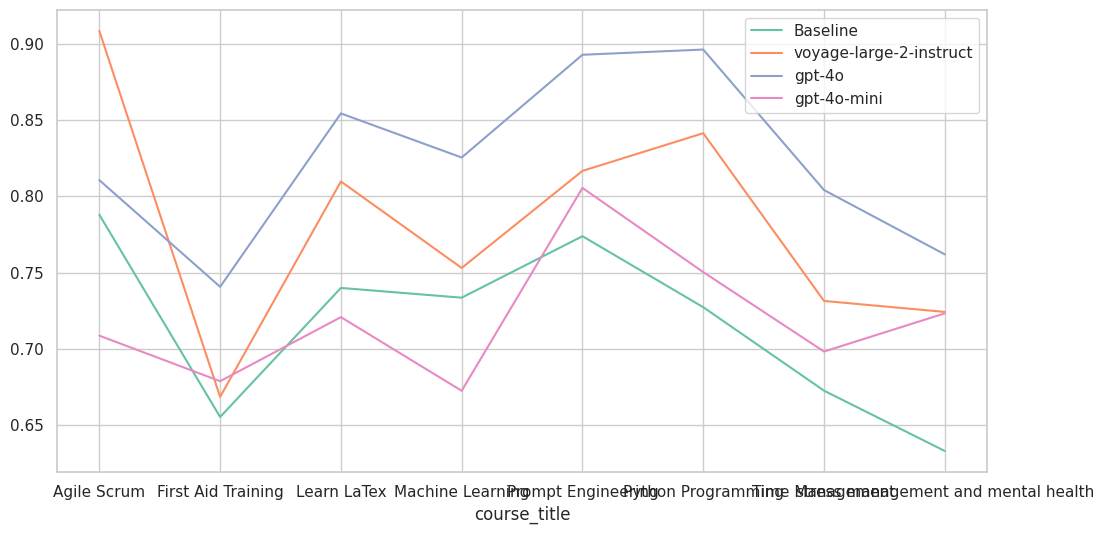

In [96]:
ax = final_plot.drop('title',axis=1).plot(kind="line", figsize=(12,6),)
ax.set_xlabel("Area")


In [48]:
y_sns = final_plot.drop("title",axis=1).reset_index().melt(id_vars="course_title",value_vars=["Baseline","voyage-large-2-instruct","gpt-4o","gpt-4o-mini"],value_name="accuracy",var_name = "model_name")
y_sns.head()

,course_title,model_name,accuracy
0,Agile Scrum,Baseline,0.787964
1,First Aid Training,Baseline,0.655093
2,Learn LaTex,Baseline,0.739883
3,Machine Learning,Baseline,0.733479
4,Prompt Engineering,Baseline,0.773866


In [59]:
rename_dict= {"Agile Scrum":"Agile Project Management","Learn LaTex":"Using LaTex","stress\nmanagement\nand mental\nhealth":"Mental health",}

array(['Agile Scrum', 'First Aid\nTraining', 'Learn LaTex',
       'Machine\nLearning', 'Prompt\nEngineering', 'Python\nProgramming',
       'Time\nManagement', 'stress\nmanagement\nand mental\nhealth'],
      dtype=object)

In [67]:
h = plot.reset_index().melt(id_vars="course_title",value_vars=["Baseline","voyage-large-2-instruct","gpt-4o","gpt-4o-mini"],value_name="accuracy",var_name = "model_name")
h.rename(columns={"model_name":"Model"}, inplace=True)

rename_dict= {"Agile Scrum":"Agile Project Management","Learn LaTex":"Using LaTex","stress management and mental health":"Mental health",}
h["course_title"] = h["course_title"].apply(lambda x: rename_dict.get(x,x))
# h.rename(columns={"model_name":"Model"}, inplace=True)

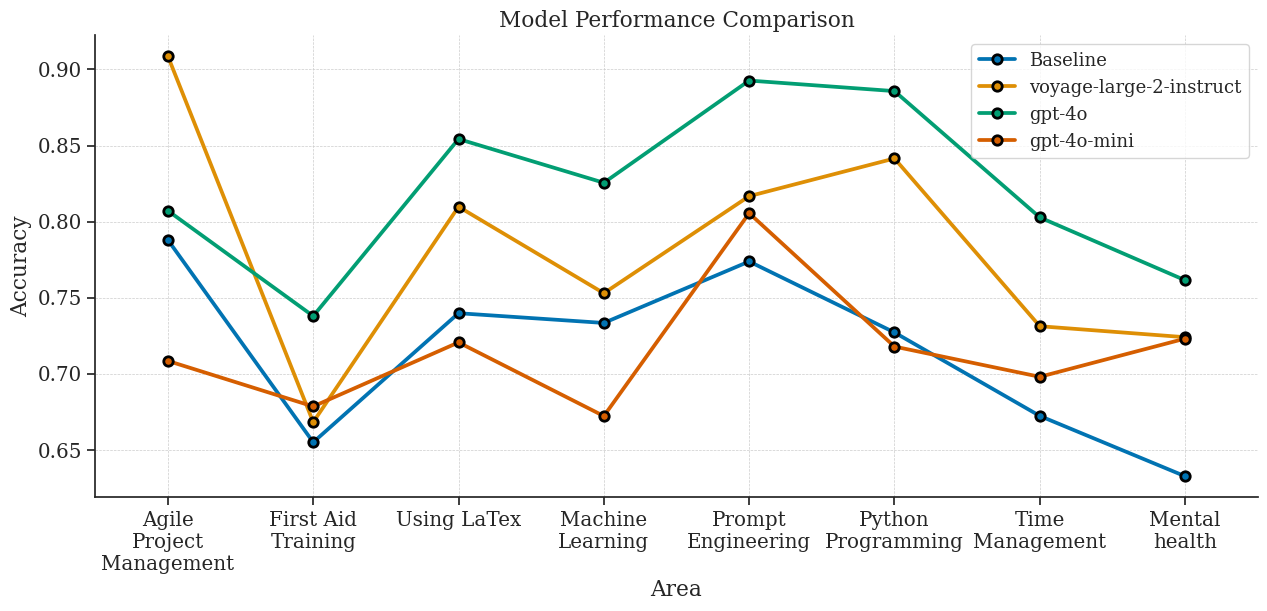

In [72]:
# sns.set_context("paper")
# sns.set(rc={"figure.figsize":(12, 6)})
# sns.set_style("whitegrid")
# sns.set_palette("Set2")
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    # "grid.color": "1",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    # "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    # 'font.size': 29
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    # "axes.edgecolor": "0.8",
}
from textwrap import wrap
sns.set_theme(style="ticks", rc=custom_params, palette="colorblind", font_scale=1.3,)
h["course_title"] = ['\n'.join(wrap(x, 12)) for x in  h['course_title']]
# h.rename(columns={"model_name":"Model"}, inplace=True)
fig,ax = plt.subplots(figsize=(15,6))
ax = sns.pointplot(data=h, x="course_title", y="accuracy", hue="Model",errorbar=None,markeredgecolor="black")
# sns.despine()
# sns.pointplot(data=h, x="course_title", y="accuracy", hue="model_name", ax=ax,errorbar=None,markeredgecolor="black")
# sns.scatterplot(data=h, x="course_title", y="accuracy", hue="model_name", ax=ax)
# ax.set_yscale("")
ax.set_xlabel("Area")
ax.set_ylabel("Accuracy")
# rotate x labels by 45
# plt.xticks(rotation=90);
plt.grid(True);
plt.title("Model Performance Comparison");
# plt.rcParams.update({'font.size': 22})
plt.legend(fontsize='small')
plt.savefig("wsdm_performance_2.pdf", bbox_inches='tight', dpi=300)
# reduce fint size for legend only

# movel legend outside the
# increase fint size



In [63]:
h = plot.reset_index().melt(id_vars="course_title",value_vars=["Baseline","voyage-large-2-instruct","gpt-4o","gpt-4o-mini"],value_name="accuracy",var_name = "model_name")

In [282]:
old_perf.sort_values("title")

,title,voyage-large-2-instruct,Baseline
0,Acute vs Chronic Stress,0.803030,0.730303
1,Body's reaction to Stress,0.722222,0.623016
2,Chain of Thought Prompting,0.617172,0.531313
3,Comments in Python,1.000000,0.988889
4,Conditions in Python,0.653061,0.537415
5,Cross Validation,0.837302,0.829365
6,Density-based Clustering,0.750000,0.750000
7,Dictionaries in Python,0.792857,0.533333
8,Error Handling in Python,0.801020,0.724490
9,Eustress vs Distress: Understanding Positive a...,0.692063,0.711111


In [283]:
r

,topic_id,status,resource_id,content,n_tokens
title,,,,,
Acute vs Chronic Stress,20,20,20,20,20
Arithmetics in Python,16,16,16,16,16
Body's reaction to Stress,16,16,16,16,16
Chain of Thought Prompting,20,20,20,20,20
Comments in Python,9,9,9,9,9
Conditions in Python,14,14,14,14,14
Cross Validation,17,17,17,17,17
Density-based Clustering,14,14,14,14,14
Dictionaries in Python,17,17,17,17,17
